In [95]:
#130713

# Course Work 1

## Exercise 3

In this exercise, you will implement the the forward and backpropagation algorithms to train a neural network. Please read the instructions in the pdf provided in e-class.

In [96]:
# Here your ID:
import numpy as np
import matplotlib.pyplot as plt #can be reeplaced by other libraries
import pandas as pd
#is not allowed to use libraries besides the ones here besides reeplacing matplotlib

In [97]:
# --- activation functions and it's derivative ---
def sigmoid(x):
    """
    compute sigmoid activation
    """
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    """
    compute derivative of sigmoid activation
    """
    return sigmoid(x) * (1 - sigmoid(x))

def identity(x):
    """
    identity function
    """
    return x

def identity_deriv(x):
    """
    derivative of identity function
    """
    return 1

# --- loss functions and it's derivative ---
def mse(y_true, y_pred):
    """
    compute mean squared error (MSE)
    """
    return np.mean(np.power(y_true-y_pred, 2))

def mse_prime(y_true, y_pred):
    """
    compute derivative of MSE. Returns error per sample, not averaged over batch.
    Averaging happens in backward_propagation.
    """
    return 2 * (y_pred - y_true)

# --- Classes ---
class MyStandardScaler:
    """
    custom implementation of standard scaler for feature scaling.
    """
    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        self.scale_ = np.std(X, axis=0)
        self.scale_[self.scale_ == 0] = 1.0

    def transform(self, X):
        return (X - self.mean_) / self.scale_

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


# --- layer ---
class Layer():
    """
    layer for neural networks. it was coded to be the layer between the hiddens (the lines in the draw)
    """
    def __init__(self, input_size, output_size, activation, activation_prime):
        """
        initialize the layer
        """
        self.input = None
        self.output = None
        self.output_without_activation = None
        self.weights = np.random.rand(input_size, output_size) * 0.1
        self.bias = np.random.rand(1, output_size) * 0.1
        self.activation = activation
        self.activation_prime = activation_prime


    def forward_propagation(self, input_data):
        """
        perform forward propagation through the layer, including activation.
        input_data is expected to be (batch_size, input_size).
        """
        self.input = input_data
        self.output_without_activation = np.dot(self.input, self.weights) + self.bias
        self.output = self.activation(self.output_without_activation)
        return self.output

    def backward_propagation(self, delta_k, learning_rate, alpha):
        """
        perform backpropagation through the layer. Use weight decay regularization.

        Args:
            delta_k: delta for each neuron from subsequent layer (shape: batch_size, output_size).
            learning_rate: learning rate for updating parameters.
            alpha: regularization parameter.

        Returns:
            delta_j: delta for each neuron in this layer (shape: batch_size, input_size)
        """
        delta_k_activated = self.activation_prime(self.output_without_activation) * delta_k
        delta_j = np.dot(delta_k_activated, self.weights.T)

        batch_size = self.input.shape[0]

        gradiente_weights = np.dot(self.input.T, delta_k_activated) / batch_size
        gradiente_bias = np.sum(delta_k_activated, axis=0, keepdims=True) / batch_size

        # Regularization term
        self.weight_decay_term = alpha * self.weights

        # Update parameters
        self.weights -= learning_rate * (gradiente_weights + self.weight_decay_term)
        self.bias -= learning_rate * gradiente_bias
        return delta_j

# --- neural network ---
class Network:
    """
    neural network model for training and prediction. put all the layers together
    """
    def __init__(self):
        """
        initialize the neural network model.
        """
        self.layers = []
        self.loss = None
        self.loss_prime = None
        self.alpha = None
        self.y_val = None
        self.x_val = None
        self.errors_during_train = []
        self.errors_during_train_val = []

    def add(self, layer):
        """
        add a layer to the network.
        """
        self.layers.append(layer)

    # set loss to use
    def use(self, loss, loss_prime, x_val, y_val, alpha = 0.1):
        """
        set usefull parameters for the network, as loss function.
        """
        self.loss = loss
        self.loss_prime = loss_prime
        self.alpha = alpha
        self.y_val = y_val
        self.x_val = x_val

    def plot_errors(self, separate = False, val_or_test = "val"):
        """
        plot the training and validation errors.

        Args:
            separate: can be used to plot train and validation in different graphs
            val_or_test: used to adapt the plot to use test dataset
        """
        if separate:
            #if you want to plot val and train in different graphs
            _, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

            axes[0].plot(self.errors_during_train, label='train')
            axes[1].plot(self.errors_during_train_val, label=val_or_test, color='orange')

            for axie in axes:
                axie.set_ylabel('Error')
                axie.legend()

            axes[1].set_xlabel('Epoch')

            string_min_error = f"minimum error (train): {min(self.errors_during_train):.5f}"
            string_min_error_val = f"minimum error ({val_or_test}): {min(self.errors_during_train_val):.5f}"

            axes[0].text(0, -0.15, string_min_error, fontstyle='italic', fontsize=9, transform=axes[0].transAxes)
            axes[1].text(0, -0.15, string_min_error_val, fontstyle='italic', fontsize=9, transform=axes[1].transAxes)

            plt.tight_layout()
            plt.show()
        else:
            #default plot, train and val together
            plt.figure(figsize=(10, 4))
            plt.plot(self.errors_during_train, label='train')
            plt.plot(self.errors_during_train_val, label=val_or_test)

            string_min_error = f"minimum error (train): {min(self.errors_during_train):.5f}"
            string_min_error_val = f"minimum error ({val_or_test}): {min(self.errors_during_train_val):.5f}"

            plt.xlabel('epoch')
            plt.ylabel('error')
            plt.title('Error during training')

            plt.legend()

            plt.text(0, -0.15, string_min_error, fontstyle='italic', fontsize = 9, transform=plt.gca().transAxes)
            plt.text(1, -0.15, string_min_error_val, fontstyle='italic', fontsize = 9 , ha='right', transform=plt.gca().transAxes)

            plt.show()

    def predict(self, input_data):
        """
        predict output for given input data, processing as a full batch.
        input_data is expected to be (n_samples, n_features).
        """
        output = input_data
        for layer in self.layers:
            output = layer.forward_propagation(output)
        return output

    def fit(self, x_train, y_train, epochs, learning_rate, tau = 1e-4 ,print_erro = False):
        """
        use backpropagation learn the weights using full-batch gradient descent.

        Args:
            x_train: training input data (shape: n_samples, n_features).
            y_train: training target data (shape: n_samples, n_outputs).
            epochs: number of training epochs.
            learning_rate: learning rate for updating parameters.
            print_erro : whether to print error during training.
        """

        previous_error = float('inf')

        # training loop
        for i in range(epochs):
            output = x_train # x_train é o 'batch' completo
            for layer in self.layers:
                output = layer.forward_propagation(output)

            # Compute loss for the full batch
            loss_train = self.loss(y_train, output)
            self.errors_during_train.append(loss_train)

            # Backward propagation
            error = self.loss_prime(y_train, output)
            for layer in reversed(self.layers):
                error = layer.backward_propagation(error, learning_rate, self.alpha)

            # Calculate the loss in the validation set
            y_pred_val = self.predict(self.x_val)
            loss_val = self.loss(self.y_val, y_pred_val)
            self.errors_during_train_val.append(loss_val)

            if print_erro: print('epoch %d/%d   error_train=%f; error_val=%f' % (i+1, epochs, loss_train, loss_val))

            if abs(previous_error - loss_train) < tau:
                print(f"Early stopping at epoch {i+1} with error {np.sqrt(loss_train):.5f}")
                break

            previous_error = loss_train


def train_test_split(X, y, test_size=0.2, random_state=None, stratify=None):
    """Simple train-test split implementation"""
    if random_state is not None:
        np.random.seed(random_state)

    n_samples = len(X)
    n_test = int(n_samples * test_size)

    if stratify is not None:
        # Stratified split
        unique_classes = np.unique(stratify)
        train_indices = []
        test_indices = []

        for class_label in unique_classes:
            class_indices = np.where(stratify == class_label)[0]
            n_class_test = int(len(class_indices) * test_size)

            np.random.shuffle(class_indices)
            test_indices.extend(class_indices[:n_class_test])
            train_indices.extend(class_indices[n_class_test:])

        train_indices = np.array(train_indices)
        test_indices = np.array(test_indices)
    else:
        # Random split
        indices = np.arange(n_samples)
        np.random.shuffle(indices)
        test_indices = indices[:n_test]
        train_indices = indices[n_test:]

    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

In [98]:
# Load data
data = pd.read_csv('Concrete_Data.csv')

# Separate features and target
X = data.iloc[:, :-1].values  # First 8 columns (features)
y = data.iloc[:, -1].values   # Last column (target)
y = y.reshape(-1, 1)  # Reshape for compatibility

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42)

print(f"Train set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

# Scale X
scaler_X = MyStandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

Train set size: 835
Validation set size: 92
Test set size: 103


In [99]:

best_rmse = float('inf')
best_params = {}

# Grid search over different hyperparameters
learning_rates = [0.1, 0.01, 0.001, 0.0001] # Ajustado learning rates
alphas = [0.0, 0.01, 0.1]  # Testar sem regularização (0.0) e com valores pequenos
architectures = [
    [64, 32],      # 2 hidden layers
    [128, 64],     # 2 hidden layers
    [32, 16, 8],   # 3 hidden layers
    [64, 32, 16, 16, 8]
]

for lr in learning_rates:
    for alpha in alphas:
        for hidden_layers in architectures:
            print(f"Testing: lr={lr}, alpha={alpha}, architecture={hidden_layers}")

            # Create network
            network = Network()

            # Add layers
            input_size = X_train_scaled.shape[1]
            prev_size = input_size

            # Add hidden layers
            for layer_size in hidden_layers:
                network.add(Layer(prev_size, layer_size, sigmoid, sigmoid_deriv))
                prev_size = layer_size

            # Add output layer (linear activation for regression)
            network.add(Layer(prev_size, 1, identity, identity_deriv))

            # Configure network - use scaled y_val
            network.use(mse, mse_prime, X_val_scaled, y_val, alpha=alpha)

            # Train network - use scaled y_train
            network.fit(X_train_scaled, y_train, epochs=100, # Aumentar epochs se necessário
                        learning_rate=lr, tau = 0.001 , print_erro=False)

            # Evaluate on validation set - predict returns scaled output
            y_pred_val = network.predict(X_val_scaled)


            # Calculate RMSE using original y_val
            rmse = np.sqrt(mse(y_val, y_pred_val))

            print(f"Validation RMSE: {rmse:.4f}")

            if rmse < best_rmse:
                best_rmse = rmse
                best_params = {
                    'learning_rate': lr,
                    'alpha': alpha,
                    'architecture': hidden_layers
                }
                best_network = network # Guarda a melhor rede (opcional, pode reconstruir)

print(f"\nBest parameters: {best_params}")
print(f"Best validation RMSE: {best_rmse:.4f}")

Testing: lr=0.1, alpha=0.0, architecture=[64, 32]
Validation RMSE: 18.0151
Testing: lr=0.1, alpha=0.0, architecture=[128, 64]
Early stopping at epoch 40 with error 16.56854
Validation RMSE: 18.0745
Testing: lr=0.1, alpha=0.0, architecture=[32, 16, 8]
Validation RMSE: 11.7065
Testing: lr=0.1, alpha=0.0, architecture=[64, 32, 16, 16, 8]
Early stopping at epoch 31 with error 16.57700
Validation RMSE: 18.0854
Testing: lr=0.1, alpha=0.01, architecture=[64, 32]
Validation RMSE: 18.0364
Testing: lr=0.1, alpha=0.01, architecture=[128, 64]
Early stopping at epoch 38 with error 16.56448
Validation RMSE: 18.0725
Testing: lr=0.1, alpha=0.01, architecture=[32, 16, 8]
Early stopping at epoch 37 with error 16.57697
Validation RMSE: 18.0863
Testing: lr=0.1, alpha=0.01, architecture=[64, 32, 16, 16, 8]
Early stopping at epoch 25 with error 16.57723
Validation RMSE: 18.0855
Testing: lr=0.1, alpha=0.1, architecture=[64, 32]
Early stopping at epoch 31 with error 16.56700
Validation RMSE: 18.0760
Testing: 

epoch 1/150   error_train=1482.824532; error_val=536.034149
epoch 2/150   error_train=606.075473; error_val=299.227762
epoch 3/150   error_train=336.101894; error_val=262.933055
epoch 4/150   error_train=284.493182; error_val=260.690902
epoch 5/150   error_train=276.412629; error_val=260.950792
epoch 6/150   error_train=274.541761; error_val=260.652409
epoch 7/150   error_train=273.475892; error_val=259.942881
epoch 8/150   error_train=272.493792; error_val=259.038001
epoch 9/150   error_train=271.497566; error_val=258.032822
epoch 10/150   error_train=270.469916; error_val=256.960591
epoch 11/150   error_train=269.403954; error_val=255.830304
epoch 12/150   error_train=268.294298; error_val=254.642268
epoch 13/150   error_train=267.136006; error_val=253.393972
epoch 14/150   error_train=265.924517; error_val=252.082304
epoch 15/150   error_train=264.655742; error_val=250.704423
epoch 16/150   error_train=263.326174; error_val=249.258185
epoch 17/150   error_train=261.933023; error_val

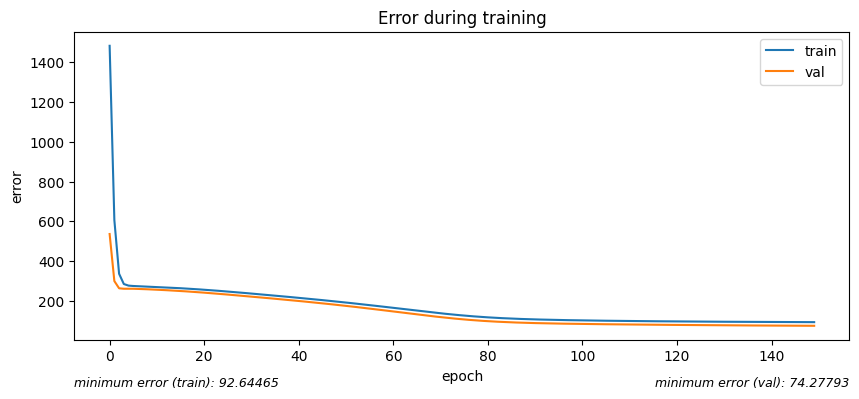


Evaluating on test set...
Test RMSE: 8.6185
Test MSE: 74.2779
Test MAE: 6.8361


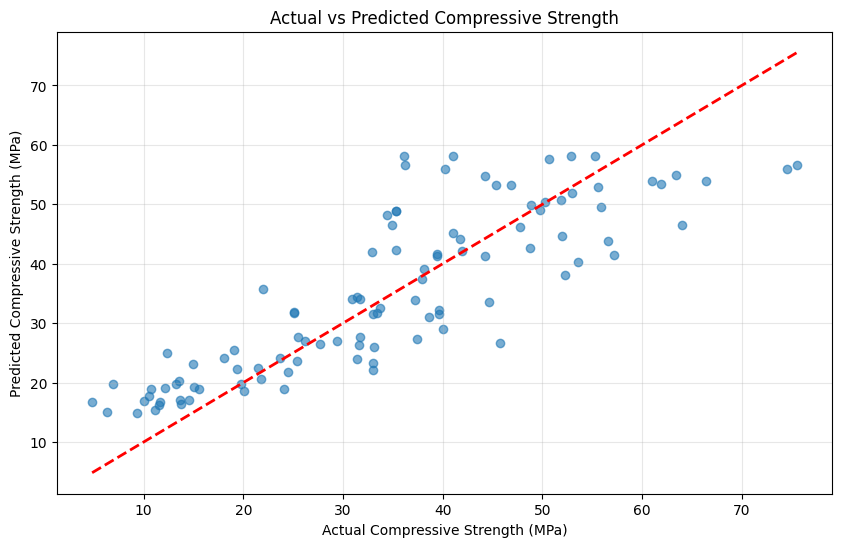

In [100]:

# Train final model with best parameters
final_network = Network()

# Concatenate training and validation sets for final training
X_train_final_scaled = np.vstack((X_train_scaled, X_val_scaled))
y_train_final = np.vstack((y_train, y_val))

# Build architecture with best parameters
input_size = X_train_final_scaled.shape[1]
prev_size = input_size

for layer_size in best_params['architecture']:
    final_network.add(Layer(prev_size, layer_size, sigmoid, sigmoid_deriv))
    prev_size = layer_size

final_network.add(Layer(prev_size, 1, identity, identity_deriv))

# Configure network using scaled X_test and y_test for final evaluation within fit loop
final_network.use(mse, mse_prime, X_test_scaled, y_test, alpha=0)

# Train with more epochs and print progress
final_network.fit(X_train_final_scaled, y_train_final, epochs=150,
                    learning_rate=best_params['learning_rate'], tau = 0.001, print_erro=True)

# Plot training curves
final_network.plot_errors()

# Evaluate on test set
print("\nEvaluating on test set...")
y_pred_test = final_network.predict(X_test_scaled)

# Calculate RMSE using original y_test
test_rmse = np.sqrt(mse(y_test, y_pred_test))
print(f"Test RMSE: {test_rmse:.4f}")

# Additional metrics using original y_test
test_mse = np.mean((y_test - y_pred_test) ** 2)
test_mae = np.mean(np.abs(y_test - y_pred_test))

print(f"Test MSE: {test_mse:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.6)
# Plot line x=y
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Compressive Strength (MPa)')
plt.ylabel('Predicted Compressive Strength (MPa)')
plt.title('Actual vs Predicted Compressive Strength')
plt.grid(True, alpha=0.3)
plt.show()